This is the project for Machine Learning at UA. 
First, we import the datasets into the notebook after we downloaded the files from the website.

## Data Import

In [1]:
# import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# read csv files
cleveland_df   = pd.read_csv("processed.cleveland.data", header=None, na_values =["?", -9.0])
switzerland_df = pd.read_csv("processed.switzerland.data", header=None, na_values =["?", -9.0])
va_df          = pd.read_csv("processed.va.data", header=None, na_values =["?", -9.0])
hungarian_df   = pd.read_csv("processed.hungarian.data", header=None, na_values =["?", -9.0])

Now we need to organize the data and add headers to the data frames. 

In [2]:
#add a column to keep track of the source of the data
cleveland_df["Source"] = "cleveland"
switzerland_df["Source"] = "switzerland"
va_df["Source"] = "va"
hungarian_df["Source"] = "hungarian"

In [3]:
# add headers to the data frames
headers = {0 : "age",
               1 : "sex",
               2 : "cp",
               3 : "trestbps",
               4 : "chol",
               5 : "fbs",
               6 : "restecg",
               7 : "thalach",
               8 : "exang",
               9 : "oldpeak",
               10 : "slope",
               11 : "ca",
               12 : "thal",
               13 : "diagnosis"}

cleveland_df = cleveland_df.rename(columns=headers)
switzerland_df = switzerland_df.rename(columns=headers)
va_df = va_df.rename(columns=headers)
hungarian_df = hungarian_df.rename(columns=headers)

Now we want to combine the different datasets from Cleveland, Switzerland, Va and Hungary into one big dataset. 

In [4]:
heart_disease_df = pd.concat([cleveland_df, switzerland_df, va_df, hungarian_df])

Next, we want to look at some details of the dataset. 

In [5]:
print(heart_disease_df.head())
print()
print(heart_disease_df.info())
print()

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  diagnosis     Source  
0    3.0  0.0   6.0          0  cleveland  
1    2.0  3.0   3.0          2  cleveland  
2    2.0  2.0   7.0          1  cleveland  
3    3.0  0.0   3.0          0  cleveland  
4    1.0  0.0   3.0          0  cleveland  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 920 entries, 0 to 293
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        920 non-null    float64
 1   sex        920 non-null    float64
 2   cp

Next, let's use the command from the lecture to describe the data. 

In [6]:
heart_disease_df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
count,920.000000,920.000000,920.000000,861.000000,890.000000,830.000000,918.000000,865.000000,865.000000,858.000000,611.000000,309.000000,434.000000,920.000000
mean,53.510870,0.789130,3.250000,132.132404,199.130337,0.166265,0.604575,137.545665,0.389595,0.878788,1.770867,0.676375,5.087558,0.995652
std,9.424685,0.408148,0.930969,19.066070,110.780810,0.372543,0.805827,25.926276,0.487941,1.091226,0.619256,0.935653,1.919075,1.142693
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,1.000000,0.000000,3.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,175.000000,0.000000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,223.000000,0.000000,0.000000,140.000000,0.000000,0.500000,2.000000,0.000000,6.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,268.000000,0.000000,1.000000,157.000000,1.000000,1.500000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


Let's collect some more information concerning the dataset. 


In [7]:
print(heart_disease_df.shape)
print(heart_disease_df.size)

(920, 15)
13800


Some more analytics. There are 920 observations with 15 14 features each, resulting in one diagnosis.

In [8]:
heart_disease_df.corr(method = 'pearson')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
age,1.000000,0.056889,0.166245,0.244253,-0.086234,0.233726,0.212719,-0.365778,0.201626,0.258243,0.155032,0.370416,0.137298,0.339596
sex,0.056889,1.000000,0.170392,0.001087,-0.197281,0.089191,-0.015612,-0.179320,0.181420,0.103930,0.125154,0.094123,0.373927,0.259342
cp,0.166245,0.170392,1.000000,0.025075,-0.132576,0.039838,0.031101,-0.349189,0.419384,0.244245,0.202989,0.214975,0.313150,0.397896
trestbps,0.244253,0.001087,0.025075,1.000000,0.092853,0.160235,0.098857,-0.104899,0.152328,0.161908,0.063387,0.093705,0.107555,0.122291
chol,-0.086234,-0.197281,-0.132576,0.092853,1.000000,0.024847,0.116494,0.236121,-0.034557,0.047734,-0.059276,0.051606,-0.179903,-0.231547
fbs,0.233726,0.089191,0.039838,0.160235,0.024847,1.000000,0.132347,-0.053386,0.029176,0.055277,0.092142,0.149539,0.105871,0.155533
restecg,0.212719,-0.015612,0.031101,0.098857,0.116494,0.132347,1.000000,0.053120,0.032331,0.118297,-0.014771,0.139154,-0.040084,0.140089
thalach,-0.365778,-0.179320,-0.349189,-0.104899,0.236121,-0.053386,0.053120,1.000000,-0.356439,-0.151174,-0.360622,-0.264094,-0.327360,-0.366265
exang,0.201626,0.181420,0.419384,0.152328,-0.034557,0.029176,0.032331,-0.356439,1.000000,0.392492,0.319424,0.127385,0.340737,0.388408
oldpeak,0.258243,0.103930,0.244245,0.161908,0.047734,0.055277,0.118297,-0.151174,0.392492,1.000000,0.421184,0.281817,0.254391,0.443084


Analyse the Pearson correlation coefficient, to find connections within the dataset. 

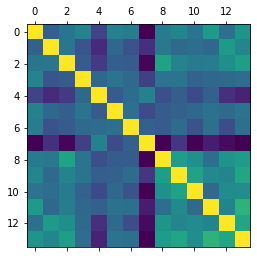

In [9]:
plt.matshow(heart_disease_df.corr())
plt.show()

In [10]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = heart_disease_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
age,1.000000,0.056889,0.166245,0.244253,-0.086234,0.233726,0.212719,-0.365778,0.201626,0.258243,0.155032,0.370416,0.137298,0.339596
sex,0.056889,1.000000,0.170392,0.001087,-0.197281,0.089191,-0.015612,-0.179320,0.181420,0.103930,0.125154,0.094123,0.373927,0.259342
cp,0.166245,0.170392,1.000000,0.025075,-0.132576,0.039838,0.031101,-0.349189,0.419384,0.244245,0.202989,0.214975,0.313150,0.397896
trestbps,0.244253,0.001087,0.025075,1.000000,0.092853,0.160235,0.098857,-0.104899,0.152328,0.161908,0.063387,0.093705,0.107555,0.122291
chol,-0.086234,-0.197281,-0.132576,0.092853,1.000000,0.024847,0.116494,0.236121,-0.034557,0.047734,-0.059276,0.051606,-0.179903,-0.231547
fbs,0.233726,0.089191,0.039838,0.160235,0.024847,1.000000,0.132347,-0.053386,0.029176,0.055277,0.092142,0.149539,0.105871,0.155533
restecg,0.212719,-0.015612,0.031101,0.098857,0.116494,0.132347,1.000000,0.053120,0.032331,0.118297,-0.014771,0.139154,-0.040084,0.140089
thalach,-0.365778,-0.179320,-0.349189,-0.104899,0.236121,-0.053386,0.053120,1.000000,-0.356439,-0.151174,-0.360622,-0.264094,-0.327360,-0.366265
exang,0.201626,0.181420,0.419384,0.152328,-0.034557,0.029176,0.032331,-0.356439,1.000000,0.392492,0.319424,0.127385,0.340737,0.388408
oldpeak,0.258243,0.103930,0.244245,0.161908,0.047734,0.055277,0.118297,-0.151174,0.392492,1.000000,0.421184,0.281817,0.254391,0.443084


## Data Visualization

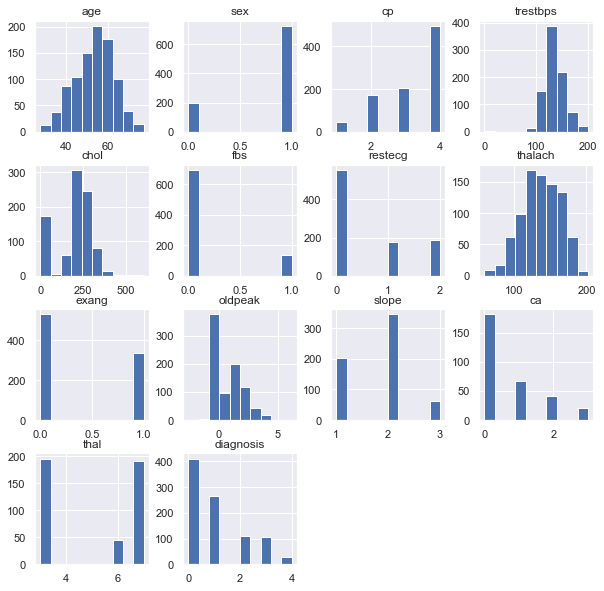

In [11]:
sns.set()
heart_disease_df.hist(figsize=(10,10))
plt.show()

<AxesSubplot:xlabel='diagnosis', ylabel='Count'>

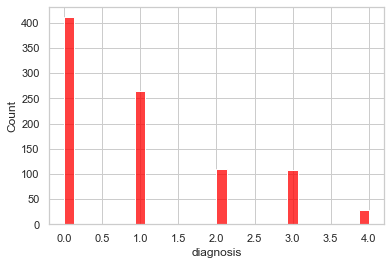

In [12]:
heart_disease_df.head()
sns.set_style('whitegrid')
sns.histplot(heart_disease_df['diagnosis'], kde = False, color ='red', bins = 30)

<AxesSubplot:xlabel='age', ylabel='diagnosis'>

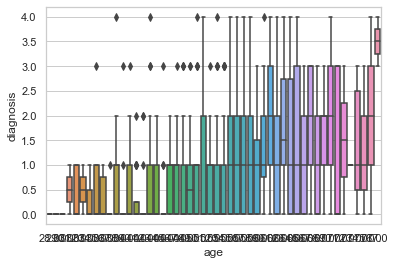

In [13]:
sns.boxplot(x='age',y='diagnosis',data=heart_disease_df)

<AxesSubplot:xlabel='ca', ylabel='diagnosis'>

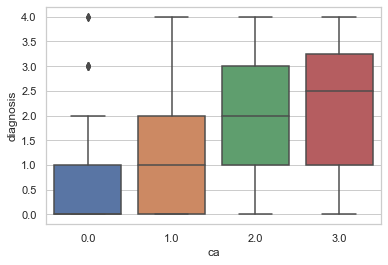

In [14]:
sns.boxplot(x='ca',y='diagnosis',data=heart_disease_df)

## Pre-Processing

In [31]:
import os
import pandas as pd
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline
import numpy as np
from sklearn.impute import SimpleImputer 

In [32]:
CONTINUOUS_FACTORS = ["age", "chol", "oldpeak", "thalach", "trestbps"]
DISCRETE_FACTORS = ["ca", "cp", "exang", "fbs", "restecg", "sex", "slope", "thal"]
TARGET = ["diagnosis"]

 
train, test = sklearn.model_selection.train_test_split(heart_disease_df, test_size=.2, random_state=10)

# split the data into the X and Y variables
trainY = train["diagnosis"].copy()
trainX = train.drop("diagnosis", axis=1)
testY = test["diagnosis"].copy()
testX = test.drop("diagnosis", axis=1)

# Handle the discrete and continuous variables seperatly
trainX_continuous = trainX[CONTINUOUS_FACTORS]
trainX_discrete = trainX[DISCRETE_FACTORS].fillna(value=5) #For all the discrete values, replace missing values with 5
testX_continuous = testX[CONTINUOUS_FACTORS]
testX_discrete = testX[DISCRETE_FACTORS].fillna(value=5) #For all the discrete values, replace missing values with 5

In [34]:
 # For continuous variables, replace missing values with the median and then normalize by subtracting the mean and dividing by the standard deviation
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

continuous_Pipeline = sklearn.pipeline.Pipeline( [("imputer", sklearn.impute.SimpleImputer(strategy="median")),
                                             ("scaler", sklearn.preprocessing.StandardScaler())
                                            ]
                                           )
trainX_continuous_scaled = continuous_Pipeline.fit_transform(trainX_continuous)

In [79]:
# for discrete variables, one-hot encode the data
discrete_Pipeline = sklearn.pipeline.Pipeline( [("one_hot", sklearn.preprocessing.OneHotEncoder(handle_unknown ='ignore'))
                                            ]
                                           )
trainX_discrete_one_hot = discrete_Pipeline.fit_transform(trainX_discrete)

print(np.size(trainX_discrete, 1))
print(np.size(trainX_discrete_one_hot, 1))


8
29


The one hot encoding increases the number of features from 8 to 29, since artificially zeros are introduced. 

In [36]:
trainX_fully_preprocessed = np.concatenate((trainX_continuous_scaled, trainX_discrete_one_hot.toarray()), axis = 1)

In [44]:
# preprocess the test data, note the use of transform instead of fit_transform
testX_continuous_scaled = continuous_Pipeline.transform(testX_continuous)
testX_discrete_one_hot = discrete_Pipeline.transform(testX_discrete)
testX_fully_preprocessed = np.concatenate((testX_continuous_scaled, testX_discrete_one_hot.toarray()), axis = 1)

In [45]:
# Convert the Y varialbe to a binary varible
trainY_binary = (trainY>0) # True if they have heart disease, False otherwide
testY_binary = (testY>0) # True if they have heart disease, False otherwide

Preprocessing done. There are two datasets: trainY_binary and trainY. 

## Train models

### SVM

In [47]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# train a SVM model using library
classifier = SVC(kernel='rbf',random_state=1,C=1,gamma='auto')
classifier.fit(trainX_fully_preprocessed,trainY)

# perform prediction on x_test data
y_pred = classifier.predict(testX_fully_preprocessed)

cm = confusion_matrix(testY,y_pred)
print(cm)
accuracy = float(cm.diagonal().sum())/len(testY)
print('model accuracy is:',accuracy*100,'%')

[[62 11  0  0  0]
 [18 36  0  0  0]
 [ 3 22  0  2  0]
 [ 5 17  0  0  0]
 [ 1  7  0  0  0]]
model accuracy is: 53.2608695652174 %


In [48]:
# now use the binary data to see whether the prediction is more easibly possible
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# train a SVM model using library
classifier = SVC(kernel='rbf',random_state=1,C=1,gamma='auto')
classifier.fit(trainX_fully_preprocessed,trainY_binary)

# perform prediction on x_test data
y_pred_binary = classifier.predict(testX_fully_preprocessed)

cm = confusion_matrix(testY_binary,y_pred_binary)
print(cm)
accuracy = float(cm.diagonal().sum())/len(testY)
print('model accuracy is:',accuracy*100,'%')

[[55 18]
 [12 99]]
model accuracy is: 83.69565217391305 %


## Neural network from class

Define activation function

In [61]:
def sigmoidGradient(z):
    """
    computes the gradient of the sigmoid function
    """
    sigmoid = 1/(1 + np.exp(-z))
    
    return sigmoid *(1-sigmoid) 


def sigmoid(z):
    """
    return the sigmoid of z
    """
    
    return 1/ (1 + np.exp(-z))

Define cost function

Inputs for cost function:
nn_params
input_layer_size
hidden_layer_size
num_labels
X
y
Lambda

In [99]:
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels, X, y,Lambda):
    """
    nn_params contains the parameters unrolled into a vector
    
    compute the cost and gradient of the neural network
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    J=0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    for i in range(1,num_labels+1):
        # y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
        y10[:, i-1] = np.where(y==i, 1, 0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
    
    cost = 1/m* J
    reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    # Implement the backpropagation algorithm to compute the gradients
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi= X[i,:] # 1 X 401
        a1i = a1[i,:] # 1 X 26
        a2i =a2[i,:] # 1 X 10
        d2 = a2i - y10[i,:]
        d1 = Theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ Theta1.T)))
        grad1= grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
        
    grad1 = 1/m * grad1
    grad2 = 1/m*grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2, reg_J, grad1_reg, grad2_reg


Random initialization

In [100]:
def randInitializeWeights(L_in, L_out):
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    """
    
    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    
    return W

Learning parameters using gradient descent

In [101]:
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        cost, grad1, grad2 = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)[3:]
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        J_history.append(cost)
    
    nn_paramsFinal = np.append(Theta1.flatten(),Theta2.flatten())
    return nn_paramsFinal , J_history

Now we need to define the parameters for our neural network. 

In [202]:
input_layer_size  = 34
hidden_layer_size = 34
num_labels = 2
num_labels_binary = 2
alpha=1 #learning rate
num_iters=5000
Lambda=0.1

# X = trainX_fully_preprocessed
# y = trainY
# y_binary = trainY_binary

In [203]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

nnTheta, nnJ_history = gradientDescentnn(trainX_fully_preprocessed,trainY_binary,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels)

Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta2 = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

Text(0.5, 1.0, 'Cost function using Gradient Descent')

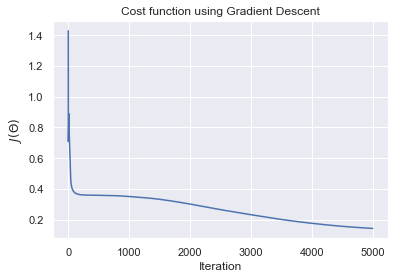

In [204]:
# Plot the cost function evolution during training.
#In order to say learning has finished, the cost function has to converge to a flat rate
plt.plot(nnJ_history)  #
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

Prediction

In [205]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    """
    m= X.shape[0]
    #Add a column of ones
  
    X = np.append(np.ones((m,1)),X, axis=1)
    
    #Compute the output of the hidden layer (with sigmoid activation functions)
    z1=np.dot(X, Theta1.T)
    a1=sigmoid(z1)
    
    #Add a column of ones
    a1 = np.append(np.ones((m,1)),a1, axis=1)
    
    #Compute the output of the output layer (with sigmoid activation functions)
    z2=np.dot(a1, Theta2.T)
    a2=sigmoid(z2)
    
    return np.argmax(a2,axis=1)+1

In [209]:
pred3 = predict(Theta1, Theta2, testX_fully_preprocessed)

m = len(testY_binary)
pred3 = pred3.reshape(m,1)
trainY_array = testY_binary.values.reshape(m,1)

print("Training Set Accuracy:",sum(pred3==trainY_array)/m*100,"%")

Training Set Accuracy: [60.32608696] %


Plot some results

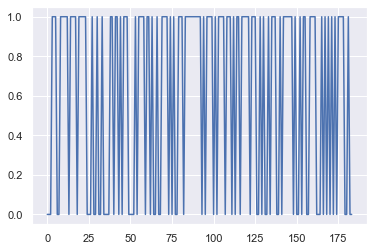

In [210]:
plt.plot(trainY_array) 

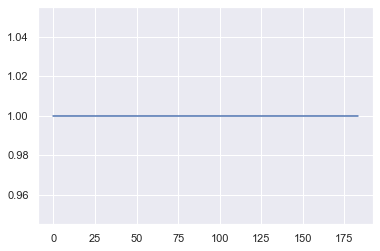

In [211]:
plt.plot(pred3)

In [191]:
pred3.shape

(736, 1)

In [193]:
trainY_array.shape

(736, 1)